# Alvienas Yandika
# alvienasyandika@gmail.com
# Kabupaten Bekasi

In [ ]:
import numpy as np
import pandas as pd
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
data = pd.read_csv('DailyDelhiClimateTrain.csv')
data.head()

,date,meantemp,humidity,wind_speed,meanpressure
0,2013-01-01,10.000000,84.500000,0.000000,1015.666667
1,2013-01-02,7.400000,92.000000,2.980000,1017.800000
2,2013-01-03,7.166667,87.000000,4.633333,1018.666667
3,2013-01-04,8.666667,71.333333,1.233333,1017.166667
4,2013-01-05,6.000000,86.833333,3.700000,1016.500000


In [ ]:
len(data)

1462

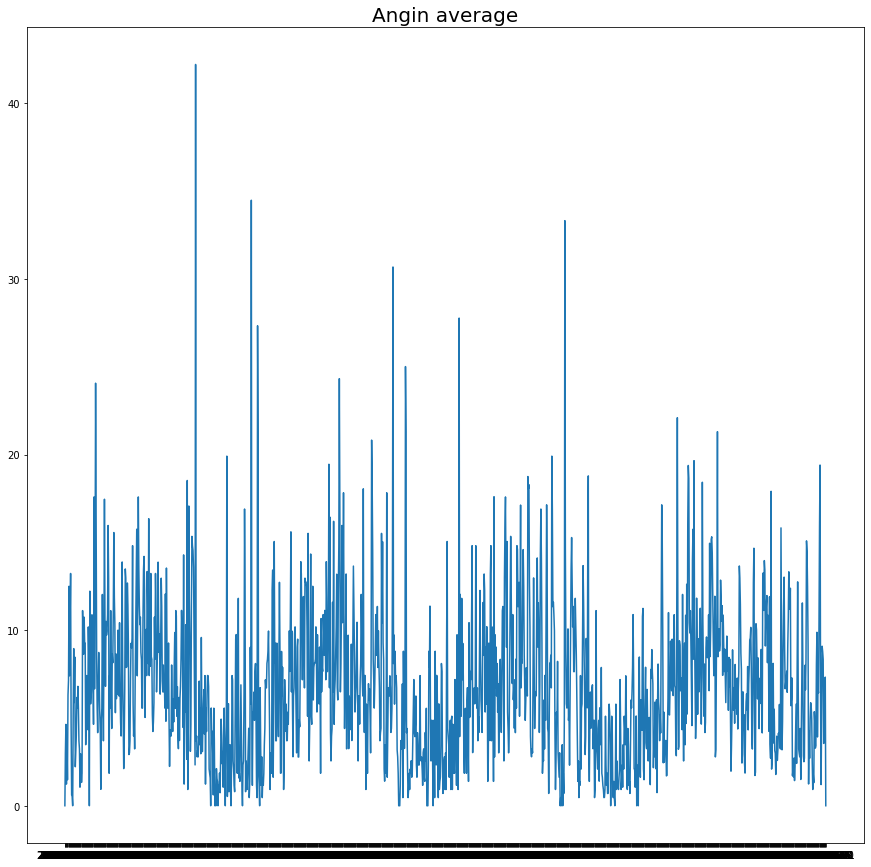

In [ ]:
date = data['date'].values
angin = data['wind_speed'].values
meantemp = data['meantemp'].values

plt.figure(figsize=(15,15))
plt.plot(date, angin)
plt.title('Angin average',
          fontsize=20);

In [ ]:
category = pd.get_dummies(data.meantemp)
df_baru = pd.concat([data, category], axis=1)
df_baru = df_baru.drop(columns='meantemp')
df_baru

,date,humidity,wind_speed,meanpressure,6.0,7.0,7.166666666666667,7.4,8.666666666666666,8.857142857142858,...,37.625,37.75,37.8,37.875,38.0,38.2,38.27272727272727,38.42857142857143,38.5,38.71428571428572
0,2013-01-01,84.500000,0.000000,1015.666667,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2013-01-02,92.000000,2.980000,1017.800000,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2013-01-03,87.000000,4.633333,1018.666667,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2013-01-04,71.333333,1.233333,1017.166667,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2013-01-05,86.833333,3.700000,1016.500000,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,2016-12-28,68.043478,3.547826,1015.565217,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1458,2016-12-29,87.857143,6.000000,1016.904762,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1459,2016-12-30,89.666667,6.266667,1017.904762,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1460,2016-12-31,87.000000,7.325000,1016.100000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
meantemp = data['meantemp'].values

In [ ]:
from sklearn.model_selection import train_test_split
angin_train, angin_test, meantemp_train, meantemp_test = train_test_split(angin, meantemp, test_size=0.2)

In [ ]:
threshold_mae = (angin.max() - angin.min()) * 10/100

In [ ]:
print(threshold_mae)

4.2219999999999995


In [ ]:
from keras.callbacks import Callback
from sklearn.metrics import mean_absolute_error

class StopCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae') < threshold_mae and logs.get('val_mae') < threshold_mae):
            print("\nNilai MAE < 10%")
            self.model.stop_training = True

In [ ]:
train_set = windowed_dataset(angin_train, window_size=60, batch_size=100, shuffle_buffer=1000)
test_set = windowed_dataset(angin_test, window_size=60, batch_size=100, shuffle_buffer=1000)
model = tf.keras.models.Sequential([
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
])

In [ ]:
data.isna().sum()

date            0
meantemp        0
humidity        0
wind_speed      0
meanpressure    0
dtype: int64

In [ ]:
optimizer = tf.keras.optimizers.SGD(lr=1.0000e-02, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"]
              )


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(train_set, 
                    validation_data = test_set, 
                    epochs=100, 
                    callbacks=[StopCallback()], 
                    verbose=2)

Epoch 1/100
12/12 - 8s - loss: 5.9328 - mae: 6.4198 - val_loss: 5.4712 - val_mae: 5.9474 - 8s/epoch - 672ms/step
Epoch 2/100
12/12 - 1s - loss: 3.7771 - mae: 4.2479 - val_loss: 3.5999 - val_mae: 4.0772 - 1s/epoch - 99ms/step
Epoch 3/100

Nilai MAE < 10%
12/12 - 1s - loss: 3.1084 - mae: 3.5772 - val_loss: 3.1924 - val_mae: 3.6569 - 1s/epoch - 98ms/step
